# ACTIVITY: A CLASSIFIER

The goal of this activity is to practice building and discussing a classifier. By the end of the activity, you should be able to justify your design decisions according to 

TASK:

In [21]:
import kagglehub
import os
import pandas as pd
from pathlib import Path

path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
print(os.listdir(path))
df = pd.read_csv(Path(path) / "bbc-news-data.csv", sep='\t')

['bbc-news-data.csv']


In [22]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## Baseline classifier

We will start with a baseline classifier. It is a simple Bag-of-words classifier.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
acc_bow = accuracy_score(y_test, y_pred)


               precision    recall  f1-score   support

     business       0.95      0.97      0.96       115
entertainment       0.97      0.94      0.96        72
     politics       0.96      0.95      0.95        76
        sport       0.99      0.99      0.99       102
         tech       0.95      0.95      0.95        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



## PART 1: preparation

Answer the questions below as comments in the following cell. In your answers, avoid using common sense. Use adequate jargons.

### Question 1: What is the underlying premise of the Bag-of-Words classifier, that is, why does BoW allow to classify these texts?

* Classifica de acordo com a contagem de palavras sem levar em consideração o contexto, então se uma palavra aparece dentro de uma categoria muitas vezes ela vai ter mais peso
* Tfidf leva e consideração a raridade da palavra no dataset

Em BoW, cada palavra do vocabulário é representada como um valor em uma dimensão de um vetor que representa o documento como um todo. No processo de classificação, cada uma dessas dimensões é multiplicada por um peso específico, gerando os logits para classificação. Isso permite classificar textos de acordo com a presença ou ausência de determinadas palavras. A vantagem de BoW é que é fácil interpretar, pois sabemos quais palavras foram usadas para a classificação. A sua principal desvantagem é que não leva em consideração o contexto em que cada palavra aparece.

### Question 2: What is the underlying premise of a BERT-based classifier, that is, why should BERT embeddings be interesting to classify these texts?


BERT foi pré-treinado para resolver a tarefa close e a tarefa de predição de próxima sentença. A consequência disso é que BERT gera embeddings densos para cada documento e documentos que geram respostas próximas nestas tarefas estão mapeados para posições próximas no espaço de embeddings. Em alguns contextos, essa procimidade é interpretada como o mapeamento de proximidades semânticas para proximidades no espaço euclidiano. Por isso, os embeddings de BERT podem ser usados em uma Regressão Logística para classificar documentos. A vantagem dos embeddings de BERT é que os embeddings densos não dependem de treinamento de vocabulário específico para cada tarefa. A desvantagem é que é mais difícil de interpretar esses embeddings, uma vez que não podemos acessar exatamente o que leva uma frase a ser mapeada sobre um ponto específico. Além disso, BERT depende de um pré-treino, e, portanto, é limitado aos contextos em que foi pré-treinado.

## PART 2: action

(a) Make a classifier that uses BERT embeddings to categorize the texts in the dataset we have discussed.

(b) Make a bar plot comparing the accuracy of the BERT-based classifier to that of the Bag-of-Words classifier

(c) Use a PCA or a T-SNE plot to visualize the documents in the newsgroups dataset in the embedding space provided by BERT. Analyze the plot taking into account the confusion matrix or the classification report of your BERT-based classifier.




In [24]:
#ex2

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

embeddings = []
for i in tqdm(range(len(df['content']))):
    e = get_embeddings(df['content'][i], model, tokenizer)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_embeddings.npy', embeddings)

100%|██████████| 2225/2225 [26:45<00:00,  1.39it/s] 


In [25]:
embeddings = np.load('bert_embeddings.npy')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(embeddings, df['category'], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
acc_bert = accuracy_score(y_test, y_pred)

               precision    recall  f1-score   support

     business       0.97      0.96      0.96       115
entertainment       0.97      0.97      0.97        72
     politics       0.95      0.97      0.96        76
        sport       1.00      0.99      1.00       102
         tech       0.96      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



[[0.95652174 0.         0.03478261 0.         0.00869565]
 [0.01388889 0.97222222 0.         0.         0.01388889]
 [0.01315789 0.         0.97368421 0.         0.01315789]
 [0.00980392 0.         0.         0.99019608 0.        ]
 [0.         0.025      0.         0.         0.975     ]]


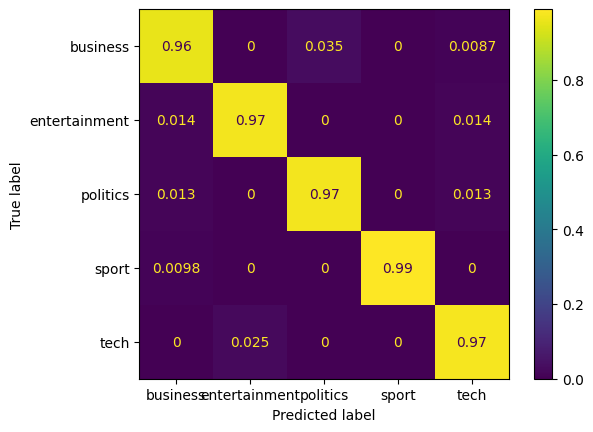

In [26]:
# confusion matrix
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=clf.classes_).plot()

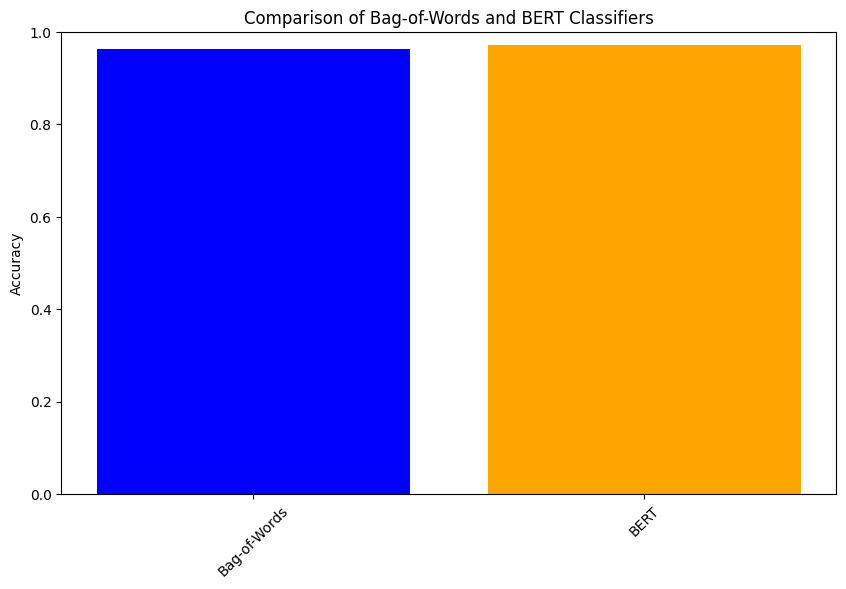

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(['Bag-of-Words', 'BERT'], [acc_bow, acc_bert], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of Bag-of-Words and BERT Classifiers')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

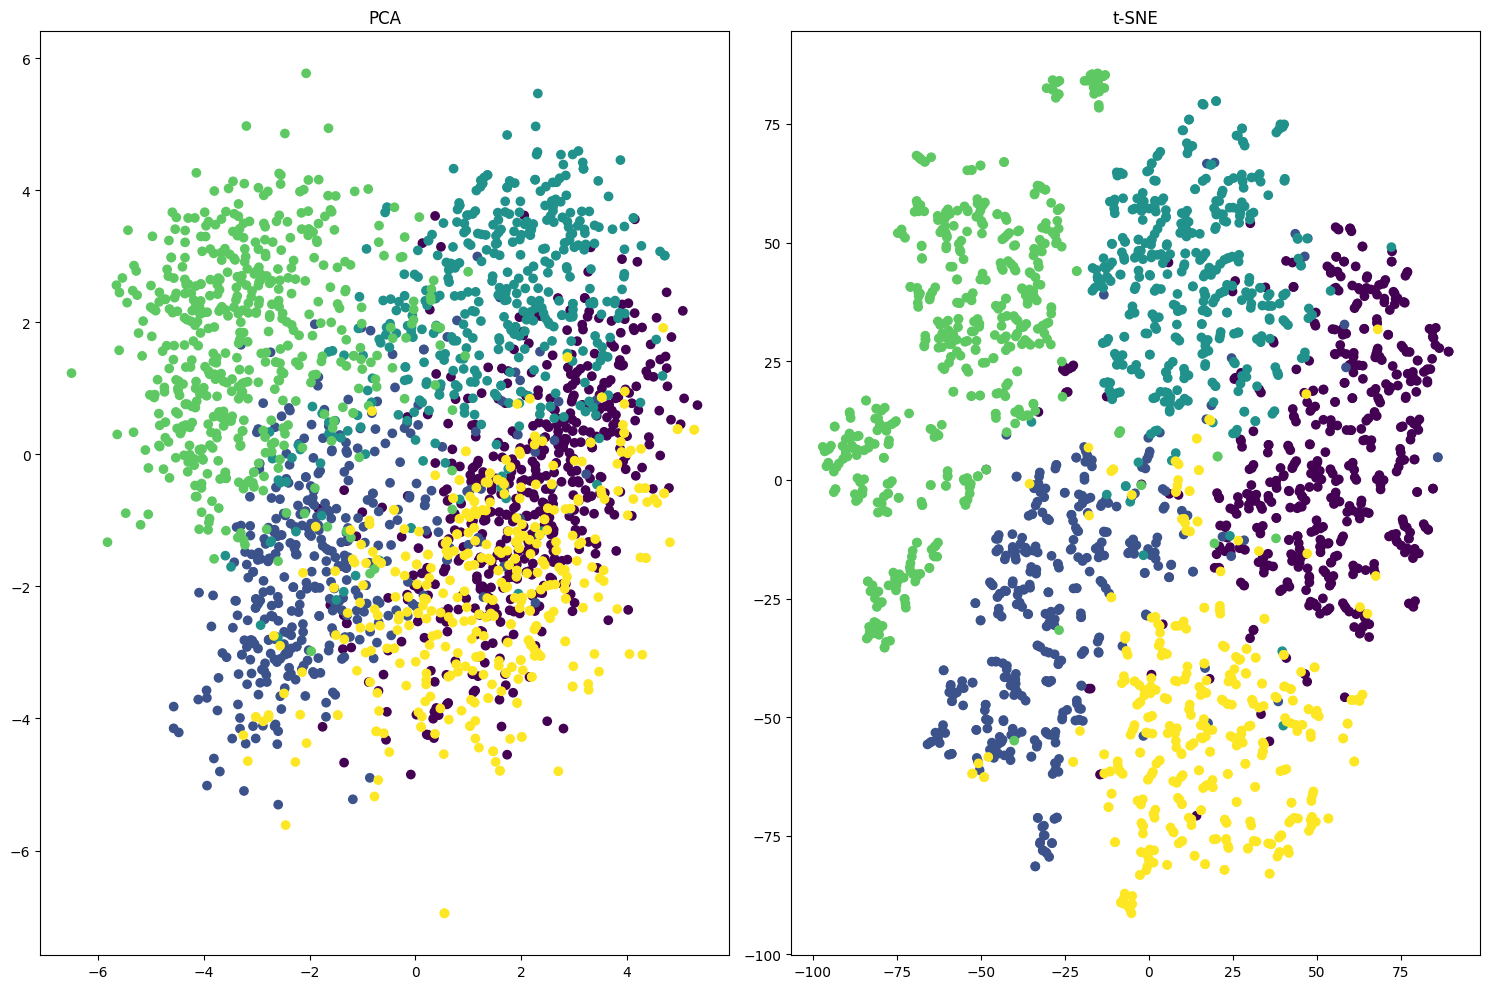

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
embeddings_pos_pca = pca.fit_transform(embeddings)
tsne = TSNE(n_components=2, perplexity=5)
embeddings_pos_tsne = tsne.fit_transform(embeddings)


plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.scatter(embeddings_pos_pca[:,0], embeddings_pos_pca[:,1], c=df['category'].astype('category').cat.codes)
plt.title('PCA')
plt.subplot(1,2,2)
plt.scatter(embeddings_pos_tsne[:,0], embeddings_pos_tsne[:,1], c=df['category'].astype('category').cat.codes)
plt.title('t-SNE')
plt.tight_layout()
plt.show()

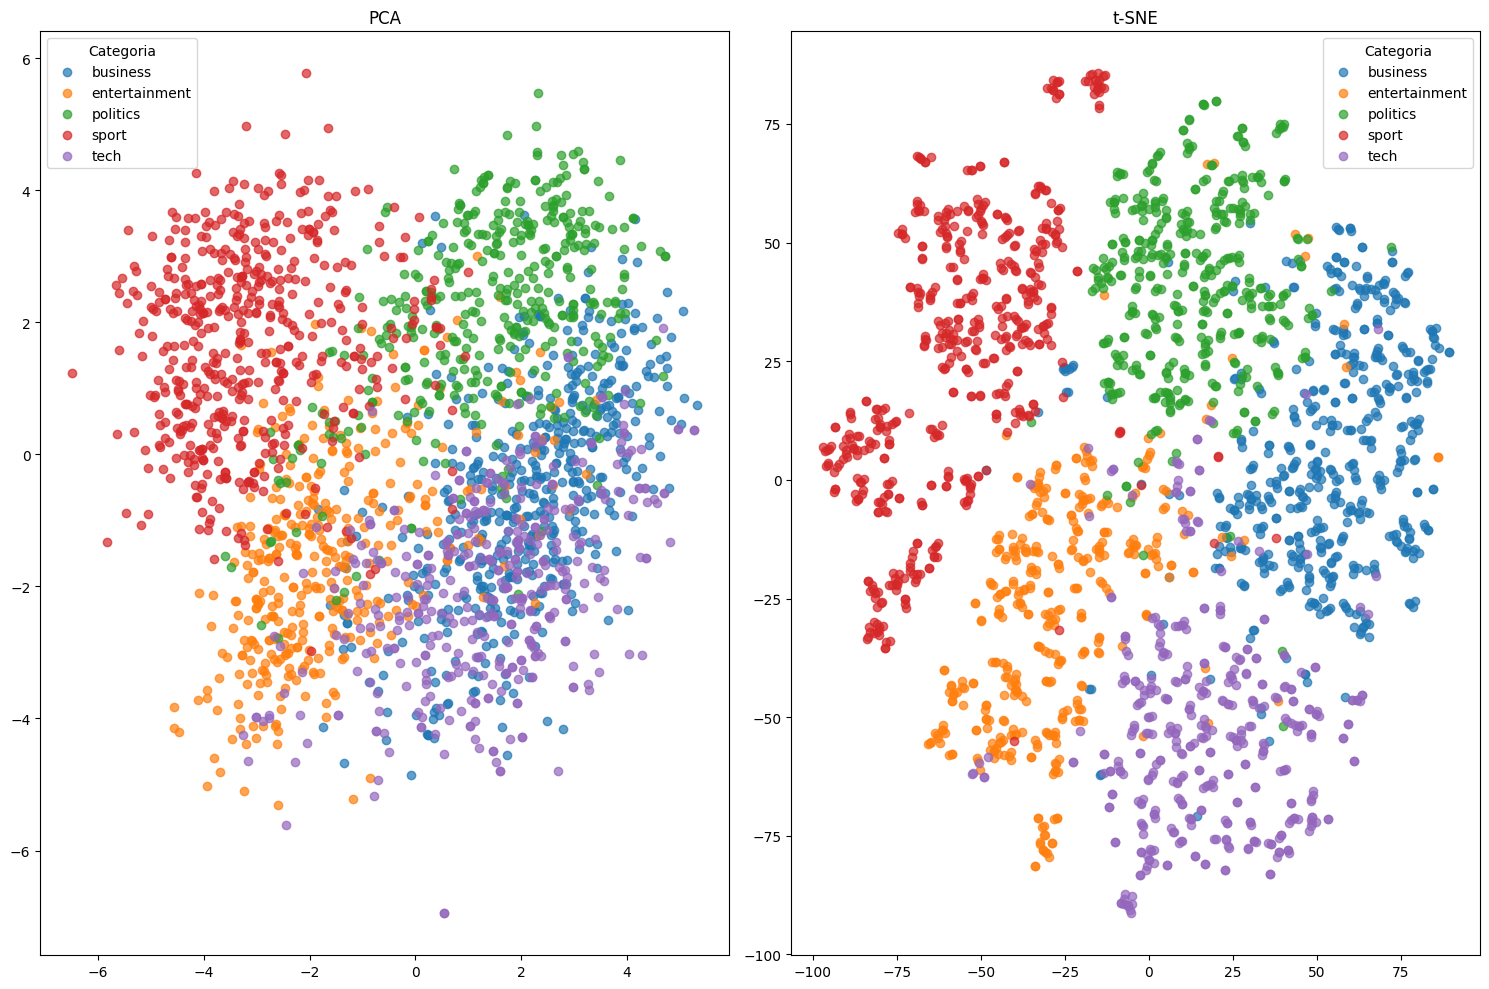

In [29]:
import matplotlib.pyplot as plt
import numpy as np

cats = df['category'].astype('category')
codes = cats.cat.codes.values
labels = cats.cat.categories

plt.figure(figsize=(15, 10))

# PCA
ax1 = plt.subplot(1, 2, 1)
for code, label in enumerate(labels):
    idx = np.where(codes == code)
    ax1.scatter(
        embeddings_pos_pca[idx, 0],
        embeddings_pos_pca[idx, 1],
        label=label,
        alpha=0.7    # só pra deixar um pouco translúcido
    )
ax1.set_title('PCA')
ax1.legend(title='Categoria')

# t-SNE
ax2 = plt.subplot(1, 2, 2)
for code, label in enumerate(labels):
    idx = np.where(codes == code)
    ax2.scatter(
        embeddings_pos_tsne[idx, 0],
        embeddings_pos_tsne[idx, 1],
        label=label,
        alpha=0.7
    )
ax2.set_title('t-SNE')
ax2.legend(title='Categoria')

plt.tight_layout()
plt.show()
